# Aspect-Based Sentiment Analysis on Glassdoor Reviews

In [949]:
import pandas as pd
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from numpy import dot
from numpy.linalg import norm
from sklearn.metrics import accuracy_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.metrics import classification_report

In [98]:
# Load SpaCy model with pre-trained vectors (large English model)
nlp = spacy.load("en_core_web_lg")

In [100]:
# Load Glassdoor reviews and create a combined column from pros and cons
df = pd.read_csv("filtered_glassdoor_reviews.csv")  
df["review_text"] = df["pros"].fillna("") + " " + df["cons"].fillna("")

/var/folders/sv/_84wsycj1tqbnb1ml2zhxz680000gn/T/ipykernel_97117/2848095970.py:2: DtypeWarning: Columns (12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("filtered_glassdoor_reviews.csv")


In [102]:
df.columns

Index(['firm', 'job_title', 'date_review', 'overall_rating',
       'work_life_balance', 'Company Culture', 'career_opp', 'comp_benefits',
       'Management', 'pros', 'cons', 'industry', 'work_life_balance.1',
       'Company Culture.1', 'career_opp.1', 'comp_benefits.1', 'Management.1',
       'review_text'],
      dtype='object')

In [104]:
# Drop unneeded columns
cols_to_drop = [
    'date_review', 'overall_rating',
       'work_life_balance', 'Company Culture', 'career_opp', 'comp_benefits',
       'Management', 'pros', 'cons', 'industry', 'work_life_balance.1',
       'Company Culture.1', 'career_opp.1', 'comp_benefits.1', 'Management.1'
]

df = df.drop(columns=cols_to_drop)

In [106]:
df.head()

,firm,job_title,review_text
0,American-Express,Team Leader,American Express is one of the most admired co...
1,American-Express,Travel Coordinator,"The benefits, flexible work hours, room for gr..."
2,American-Express,Team Leader,Stable company on Dow Jones and more than 150 ...
3,American-Express,Senior Manager,American Express has great people who are smar...
4,American-Express,Director,"Working with smart, mainly dedicated individua..."


In [108]:
# Tokenize and collect useful lemmatized tokens (nouns & adjectives, no stopwords)
all_tokens = []

for review in tqdm(df["review_text"]):
    doc = nlp(review)
    for token in doc:
        if (
            token.pos_ in ["NOUN", "ADJ"]
            and not token.is_stop
            and token.is_alpha
            and len(token.text) > 2
        ):
            all_tokens.append(token.lemma_.lower())

100%|██████████████████████████████████| 377529/377529 [58:38<00:00, 107.30it/s]


In [110]:
# Count word frequencies and select high-frequency candidates (appearing >= 10 times)
token_freq = Counter(all_tokens)

In [112]:
# Select top-N words based on frequency threshold
candidate_words = [word for word, freq in token_freq.most_common(300) if freq >= 10]
print(f"Top 30 candidate words:\n{candidate_words[:30]}")

Top 30 candidate words:
['good', 'work', 'great', 'people', 'company', 'life', 'opportunity', 'lot', 'balance', 'hour', 'benefit', 'time', 'management', 'employee', 'culture', 'environment', 'team', 'salary', 'career', 'place', 'project', 'job', 'long', 'pay', 'manager', 'year', 'experience', 'growth', 'high', 'training']


In [128]:
# Define function for Vector Similarity 
def mean_vector(text):
    doc = nlp(text)
    vectors = [token.vector for token in doc if token.has_vector]
    return sum(vectors) / len(vectors) if vectors else None

def cosine_sim(v1, v2):
    return dot(v1, v2) / (norm(v1) * norm(v2))

In [158]:
# Define initial aspects with seed terms for similarity comparison
threshold = 0.615
max_expansion = 15

aspects = {
    "Management": "manager supervisor leadership boss management",
    "Work-Life Balance": "workload flexible overtime hours schedule work-life",
    "Career Opportunities": "promotion training advancement career growth learning development",
    "Compensation & Benefits": "salary bonus healthcare compensation benefits pay insurance",
    "Company Culture": "values diversity environment culture ethics mission inclusion"
}

# Compute Mean Vector for each Aspect
aspect_vectors = {}
for label, seed_text in aspects.items():
    vec = mean_vector(seed_text)
    if vec is not None:
        aspect_vectors[label] = vec

# Assign each candidate word to best-fitting aspect (deduplicating by lemma)
word_assignments = {}
used_lemmas = set()

for w in candidate_words:
    w_doc = nlp(w)
    if not w_doc or not w_doc[0].has_vector:
        continue

    lemma = w_doc[0].lemma_.lower()
    if lemma in used_lemmas:
        continue

    w_vec = mean_vector(w)
    if w_vec is None:
        continue

    best_aspect = None
    best_sim = -1

    for label, vec in aspect_vectors.items():
        sim = cosine_sim(w_vec, vec)
        if sim > threshold and sim > best_sim:
            best_sim = sim
            best_aspect = label

    if best_aspect:
        word_assignments.setdefault(best_aspect, []).append((w, best_sim))
        used_lemmas.add(lemma)

# Merge seed and assigned words for each aspect
aspect_docs = {}
for label, seed_text in aspects.items():
    seeds = set(seed_text.split())
    expanded = {w for w, _ in sorted(word_assignments.get(label, []), key=lambda x: -x[1])[:max_expansion]}
    aspect_docs[label] = list(seeds | expanded)
    print(f"{label}: {' '.join(aspect_docs[label])}")


Management: staff management consultant manager leadership supervisor boss department
Work-Life Balance: hours schedule overtime workload job work-life work day flexible time
Career Opportunities: focus future advancement career experience opportunity business innovation learning training knowledge promotion development strategy growth
Compensation & Benefits: money insurance benefits health compensation employee pay financial cost salary healthcare benefit bonus
Company Culture: responsibility important mission diversity social ethics culture diverse environment values inclusion


In [160]:
# Manually remove mislabeled words per aspect
manual_deletes = {
    "Management": {"staff", "consultant"},
    "Career Opportunities": {"focus", "business", "innovation", "strategy"},
    "Compensation & Benefits": {"employee"},
    "Company Culture": {"important"}
}

# Apply manual deletions
for label, words_to_remove in manual_deletes.items():
    if label in aspect_docs:
        aspect_docs[label] = [w for w in aspect_docs[label] if w not in words_to_remove]

# Print updated aspect_docs
for label, words in aspect_docs.items():
    print(f"{label}: {' '.join(words)}")

Management: management manager leadership supervisor boss department
Work-Life Balance: hours schedule overtime workload job work-life work day flexible time
Career Opportunities: future advancement career experience opportunity learning training knowledge promotion development growth
Compensation & Benefits: money insurance benefits health compensation pay financial cost salary healthcare benefit bonus
Company Culture: responsibility mission diversity social ethics culture diverse environment values inclusion


In [162]:
# Function: Extract [ADJ + NOUN], [NOUN + NOUN], [ADJ + NOUN + NOUN], [NOUN + ADJ] Phrases from Reviews
def extract_phrases(text):
    doc = nlp(text)
    phrases = []

    def is_valid_token(token):
        t = token.text.strip()
        # Allow alphabetic or clean hyphenated compounds (e.g., "well-being")
        if re.fullmatch(r"[a-zA-Z]+(-[a-zA-Z]+)+", t):
            return True
        if t.isalpha():
            return True
        return False

    for i in range(len(doc) - 2):
        t0, t1, t2 = doc[i], doc[i+1], doc[i+2]

        # ADJ + NOUN
        if t0.pos_ == "ADJ" and t1.pos_ == "NOUN":
            if is_valid_token(t0) and is_valid_token(t1):
                phrases.append({
                    "surface": f"{t0.text} {t1.text}",
                    "lemma": f"{t0.lemma_} {t1.lemma_}"
                })

        # NOUN + NOUN
        if t0.pos_ == "NOUN" and t1.pos_ == "NOUN":
            if is_valid_token(t0) and is_valid_token(t1):
                phrases.append({
                    "surface": f"{t0.text} {t1.text}",
                    "lemma": f"{t0.lemma_} {t1.lemma_}"
                })

        # ADJ + NOUN + NOUN
        if t0.pos_ == "ADJ" and t1.pos_ == "NOUN" and t2.pos_ == "NOUN":
            if is_valid_token(t0) and is_valid_token(t1) and is_valid_token(t2):
                phrases.append({
                    "surface": f"{t0.text} {t1.text} {t2.text}",
                    "lemma": f"{t0.lemma_} {t1.lemma_} {t2.lemma_}"
                })

        # NOUN + ADJ (e.g., "data-driven", "customer-centric")
        if t0.pos_ == "NOUN" and t1.pos_ == "ADJ":
            if is_valid_token(t0) and is_valid_token(t1):
                phrases.append({
                    "surface": f"{t0.text} {t1.text}",
                    "lemma": f"{t0.lemma_} {t1.lemma_}"
                })

    return phrases

In [164]:
# Apply phrase extraction across all reviews
all_phrases = []
for review in tqdm(df["review_text"]):
    all_phrases.extend(extract_phrases(review))

100%|██████████████████████████████████| 377529/377529 [55:23<00:00, 113.58it/s]


In [174]:
all_phrases

[{'surface': 'admired companies', 'lemma': 'admired company'},
 {'surface': 'great company', 'lemma': 'great company'},
 {'surface': 'employers countless', 'lemma': 'employer countless'},
 {'surface': 'extraordinary service', 'lemma': 'extraordinary service'},
 {'surface': 'positive impact', 'lemma': 'positive impact'},
 {'surface': 'leadership development', 'lemma': 'leadership development'},
 {'surface': 'intimate learning', 'lemma': 'intimate learning'},
 {'surface': 'intimate learning sessions',
  'lemma': 'intimate learning session'},
 {'surface': 'learning sessions', 'lemma': 'learning session'},
 {'surface': 'leadership tactics', 'lemma': 'leadership tactic'},
 {'surface': 'career development', 'lemma': 'career development'},
 {'surface': 'many opportunities', 'lemma': 'many opportunity'},
 {'surface': 'influential members', 'lemma': 'influential member'},
 {'surface': 'leadership team', 'lemma': 'leadership team'},
 {'surface': 'department teamwork', 'lemma': 'department teamwo

In [473]:
# Extract just the lemma strings
lemma_phrases = [p["lemma"] for p in all_phrases]

# Count frequencies and extract most common 300 words
phrase_counts = Counter(lemma_phrases)
top_phrases = [phrase for phrase, count in phrase_counts.most_common(300)]

In [475]:
top_phrases

['life balance',
 'work life',
 'long hour',
 'good work',
 'work environment',
 'great people',
 'great place',
 'work culture',
 'good benefit',
 'good place',
 'great benefit',
 'smart people',
 'good company',
 'great work',
 'good people',
 'great company',
 'good work life',
 'big company',
 'good pay',
 'flexible work',
 'busy season',
 'good salary',
 'career growth',
 'low salary',
 'large company',
 'senior management',
 'great culture',
 'work hour',
 'good culture',
 'great opportunity',
 'growth opportunity',
 'career path',
 'career opportunity',
 'brand name',
 'great team',
 'nice people',
 'learning opportunity',
 'other company',
 'low pay',
 'great learning',
 'career progression',
 'good team',
 'good work culture',
 'good environment',
 'good opportunity',
 'new technology',
 'good training',
 'career development',
 'upper management',
 'many opportunity',
 'good exposure',
 'long term',
 'good experience',
 'interesting project',
 'good learning',
 'work pressure'

In [477]:
# Map each phrase to an aspect using vector similarity
mapped_phrases = []

for phrase in top_phrases:
    phrase_doc = nlp(phrase)
    best_aspect = None
    best_score = -1
    for aspect_name, aspect_words in aspect_docs.items():
        # Convert list of words to a single nlp Doc
        aspect_doc = nlp(" ".join(aspect_words))
        sim = phrase_doc.similarity(aspect_doc)
        if sim > best_score:
            best_score = sim
            best_aspect = aspect_name
    mapped_phrases.append((phrase, best_aspect, round(best_score, 3)))


In [478]:
# Convert to DataFrame
mapped_df = pd.DataFrame(mapped_phrases, columns=["Phrase", "Mapped Aspect", "Similarity"])
mapped_df = mapped_df.sort_values(by="Similarity", ascending=False).reset_index(drop=True)
print(mapped_df.head(50))

                        Phrase            Mapped Aspect  Similarity
0      development opportunity     Career Opportunities       0.896
1           career development     Career Opportunities       0.871
2         learning opportunity     Career Opportunities       0.871
3           flexible work hour        Work-Life Balance       0.863
4    good learning opportunity     Career Opportunities       0.862
5                work schedule        Work-Life Balance       0.856
6   great learning opportunity     Career Opportunities       0.855
7               long work hour        Work-Life Balance       0.852
8         training opportunity     Career Opportunities       0.852
9      advancement opportunity     Career Opportunities       0.850
10                   work hour        Work-Life Balance       0.849
11         learning experience     Career Opportunities       0.849
12              health benefit  Compensation & Benefits       0.848
13      flexible work schedule        Work-Life 

In [597]:
mapped_df.to_csv("mapped_reviews.csv", index=False)

In [481]:
# Build aspect (phrases dictionary)
aspect_keywords = {}
for phrase, aspect, _ in mapped_phrases:
    aspect_keywords.setdefault(aspect, []).append(phrase)

In [483]:
# Aspect-Based Sentiment Analysis Function using VADER

# Pre-lemmatize all keywords
lemmatized_keywords = {
    aspect: [nlp(kw)[0].lemma_.lower() for kw in keywords]
    for aspect, keywords in aspect_keywords.items()
}

vader = SentimentIntensityAnalyzer()
def analyze_review(review):
    doc = nlp(review)
    aspect_scores = {aspect: [] for aspect in lemmatized_keywords}

    for sent in doc.sents:
        sent_lemmas = " ".join([token.lemma_.lower() for token in sent])
        for aspect, lemmatized_kw_list in lemmatized_keywords.items():
            for kw_lemma in lemmatized_kw_list:
                if re.search(rf"\b{re.escape(kw_lemma)}\b", sent_lemmas):
                    score = vader.polarity_scores(sent.text)["compound"]
                    aspect_scores[aspect].append(score)
                    break

    averaged_scores = {
        aspect: round(sum(scores)/len(scores), 3) if scores else None
        for aspect, scores in aspect_scores.items()
    }
    return averaged_scores

In [485]:
# Apply Sentiment Analysis to All Reviews
results = []
for review in tqdm(df["review_text"], desc="Analyzing reviews"):
    results.append(analyze_review(review))

Analyzing reviews: 100%|██████████████| 377529/377529 [1:04:22<00:00, 97.75it/s]


In [489]:
aspect_df = pd.DataFrame(results)

In [643]:
print(aspect_df.head(40))

    Work-Life Balance  Company Culture  Compensation & Benefits  \
0               0.399            0.164                    0.402   
1               0.544            0.727                    0.727   
2               0.664            0.617                    0.830   
3               0.400            0.427                    0.413   
4               0.289            0.423                    0.423   
5              -0.077              NaN                      NaN   
6               0.590            0.654                    0.724   
7               0.541            0.511                    0.659   
8               0.376            0.322                    0.564   
9                 NaN            0.784                    0.000   
10              0.603            0.457                    0.931   
11              0.161            0.285                    0.358   
12              0.843            0.843                    0.612   
13             -0.448           -0.718                   -0.25

In [607]:
# List of target columns (this part is just for exploring the data)
aspect_columns = [
    "Work-Life Balance", "Company Culture", "Compensation & Benefits",
    "Career Opportunities", "Management"
]

# Filter rows where any of the specified columns has a negative score
negative_scores_df = aspect_df[aspect_df[aspect_columns].lt(0).any(axis=1)]

# Show results
print(negative_scores_df)

        Work-Life Balance  Company Culture  Compensation & Benefits  \
5                  -0.077              NaN                      NaN   
13                 -0.448           -0.718                   -0.250   
21                 -0.002              NaN                      NaN   
24                 -0.128           -0.128                   -0.128   
30                 -0.337            0.000                    0.000   
...                   ...              ...                      ...   
377493             -0.113            0.250                    0.250   
377494             -0.052           -0.052                   -0.052   
377504             -0.238            0.000                   -0.373   
377505             -0.581           -0.524                   -0.524   
377511             -0.250           -0.250                   -0.250   

        Career Opportunities  Management  
5                        NaN         NaN  
13                    -0.448      -0.448  
21                

In [887]:
# Pick a specific row index to inspect (this part is just for checking the data)
i = 377505 # Change this to any row index you want to test

# Print the review text
print(df.loc[i, "review_text"])

# Run the sentiment scoring function on it
analyze_review(df.loc[i, "review_text"])

Maternity leave of 12 weeks, student loan paydown, working from home Don't expect to be paid properly at all, you will be paid less than any other big 4 outside of KPMG perhaps; Leadership does not care at all for any of their people. They put on a good front nationally on the website, but at the market team level, no one cares about anybody especially the staff or seniors. They don't care if their seniors or staff quit and just expect the poor souls who stay behind to carry the extra load.


{'Work-Life Balance': -0.581,
 'Company Culture': -0.524,
 'Compensation & Benefits': -0.524,
 'Career Opportunities': -0.581,
 'Management': -0.657}

In [947]:
# Checking polarity scores
vader.polarity_scores("it's ok")

{'neg': 0.0, 'neu': 0.312, 'pos': 0.688, 'compound': 0.296}

In [493]:
# Combine review data with aspect scores
final_df = pd.concat([df[["firm", "job_title", "review_text"]], aspect_df], axis=1)

In [495]:
final_df.head(20)

,firm,job_title,review_text,Work-Life Balance,Company Culture,Compensation & Benefits,Career Opportunities,Management
0,American-Express,Team Leader,American Express is one of the most admired co...,0.399,0.164,0.402,0.315,0.451
1,American-Express,Travel Coordinator,"The benefits, flexible work hours, room for gr...",0.544,0.727,0.727,0.727,NaN
2,American-Express,Team Leader,Stable company on Dow Jones and more than 150 ...,0.664,0.617,0.830,0.830,0.806
3,American-Express,Senior Manager,American Express has great people who are smar...,0.400,0.427,0.413,0.502,0.605
4,American-Express,Director,"Working with smart, mainly dedicated individua...",0.289,0.423,0.423,0.289,0.423
5,American-Express,Executive Assistant,Anerican Express is a very diverse organizatio...,-0.077,NaN,NaN,NaN,NaN
6,American-Express,Customer Care Professional,"Excellent Pay, Excellent Benefits, Great Oppor...",0.590,0.654,0.724,0.708,0.000
7,American-Express,Senior Marketing Analyst,Wonderful company to work for! Amex cares abou...,0.541,0.511,0.659,0.436,0.691
8,American-Express,Director,Work life balance. Professional development. ...,0.376,0.322,0.564,0.279,0.214
9,American-Express,Director,"Easy Commute, Prestigious company, Fun day Pol...",NaN,0.784,0.000,NaN,NaN


In [497]:
# Group by firm and calculate average score per aspect
company_avg_scores = final_df.groupby("firm").mean(numeric_only=True).reset_index()

In [499]:
company_avg_scores

,firm,Work-Life Balance,Company Culture,Compensation & Benefits,Career Opportunities,Management
0,American-Express,0.448448,0.484729,0.488305,0.487971,0.465836
1,Apple,0.448280,0.493544,0.503001,0.508879,0.470167
2,Barclays,0.413791,0.448653,0.455052,0.445574,0.435265
3,Citi,0.367918,0.410243,0.412440,0.409587,0.378271
4,Deloitte,0.392470,0.423899,0.454637,0.445005,0.438910
5,EY,0.369480,0.403963,0.431630,0.420933,0.416073
6,Google,0.493222,0.517835,0.547890,0.541721,0.535174
7,HSBC-Holdings,0.386689,0.424502,0.424095,0.419282,0.414348
8,IBM,0.355512,0.385056,0.377833,0.396329,0.377568
9,J-P-Morgan,0.414908,0.452488,0.455989,0.461909,0.429016


In [501]:
# Convert sentiment scores [-1, 1] to 1–5 scale (similar to star ratings)
# Define the list of aspect columns to transform
aspect_cols = [
    "Management",
    "Work-Life Balance",
    "Career Opportunities",
    "Compensation & Benefits",
    "Company Culture"
]

# Apply transformation: [-1,1] → [1,5] to convert from VADER to a rating out of 5
for col in aspect_cols:
    company_avg_scores[f"{col} (out of 5)"] = company_avg_scores[col].apply(
        lambda x: round(2 * x + 3, 2) if pd.notnull(x) else None
    )

In [503]:
company_avg_scores

,firm,Work-Life Balance,Company Culture,Compensation & Benefits,Career Opportunities,Management,Management (out of 5),Work-Life Balance (out of 5),Career Opportunities (out of 5),Compensation & Benefits (out of 5),Company Culture (out of 5)
0,American-Express,0.448448,0.484729,0.488305,0.487971,0.465836,3.93,3.90,3.98,3.98,3.97
1,Apple,0.448280,0.493544,0.503001,0.508879,0.470167,3.94,3.90,4.02,4.01,3.99
2,Barclays,0.413791,0.448653,0.455052,0.445574,0.435265,3.87,3.83,3.89,3.91,3.90
3,Citi,0.367918,0.410243,0.412440,0.409587,0.378271,3.76,3.74,3.82,3.82,3.82
4,Deloitte,0.392470,0.423899,0.454637,0.445005,0.438910,3.88,3.78,3.89,3.91,3.85
5,EY,0.369480,0.403963,0.431630,0.420933,0.416073,3.83,3.74,3.84,3.86,3.81
6,Google,0.493222,0.517835,0.547890,0.541721,0.535174,4.07,3.99,4.08,4.10,4.04
7,HSBC-Holdings,0.386689,0.424502,0.424095,0.419282,0.414348,3.83,3.77,3.84,3.85,3.85
8,IBM,0.355512,0.385056,0.377833,0.396329,0.377568,3.76,3.71,3.79,3.76,3.77
9,J-P-Morgan,0.414908,0.452488,0.455989,0.461909,0.429016,3.86,3.83,3.92,3.91,3.90


In [505]:
# Define the 5 aspect columns
score_columns = [
    'Management (out of 5)',
    'Work-Life Balance (out of 5)',
    'Career Opportunities (out of 5)',
    'Compensation & Benefits (out of 5)',
    'Company Culture (out of 5)'
]

# Calculate the row-wise average score
company_avg_scores['Overall Average (out of 5)'] = company_avg_scores[score_columns].mean(axis=1)

In [507]:
company_avg_scores = company_avg_scores.sort_values(by='Overall Average (out of 5)', ascending=False).reset_index(drop=True)

In [509]:
company_avg_scores

,firm,Work-Life Balance,Company Culture,Compensation & Benefits,Career Opportunities,Management,Management (out of 5),Work-Life Balance (out of 5),Career Opportunities (out of 5),Compensation & Benefits (out of 5),Company Culture (out of 5),Overall Average (out of 5)
0,Google,0.493222,0.517835,0.547890,0.541721,0.535174,4.07,3.99,4.08,4.10,4.04,4.056
1,McKinsey-and-Company,0.473700,0.504050,0.557797,0.499477,0.516869,4.03,3.95,4.00,4.12,4.01,4.022
2,Apple,0.448280,0.493544,0.503001,0.508879,0.470167,3.94,3.90,4.02,4.01,3.99,3.972
3,American-Express,0.448448,0.484729,0.488305,0.487971,0.465836,3.93,3.90,3.98,3.98,3.97,3.952
4,Microsoft,0.447752,0.479995,0.499968,0.483613,0.460340,3.92,3.90,3.97,4.00,3.96,3.950
5,J-P-Morgan,0.414908,0.452488,0.455989,0.461909,0.429016,3.86,3.83,3.92,3.91,3.90,3.884
6,Barclays,0.413791,0.448653,0.455052,0.445574,0.435265,3.87,3.83,3.89,3.91,3.90,3.880
7,Deloitte,0.392470,0.423899,0.454637,0.445005,0.438910,3.88,3.78,3.89,3.91,3.85,3.862
8,PwC,0.379438,0.416629,0.441720,0.431659,0.427441,3.85,3.76,3.86,3.88,3.83,3.836
9,HSBC-Holdings,0.386689,0.424502,0.424095,0.419282,0.414348,3.83,3.77,3.84,3.85,3.85,3.828



Tukey HSD for: Management
              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
       group1               group2        meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------
    American-Express                Apple   0.0043    1.0 -0.0155  0.0242  False
    American-Express             Barclays  -0.0306 0.0004 -0.0531 -0.0081   True
    American-Express                 Citi  -0.0876    0.0 -0.1076 -0.0675   True
    American-Express             Deloitte  -0.0269    0.0 -0.0449 -0.0089   True
    American-Express                   EY  -0.0498    0.0 -0.0683 -0.0312   True
    American-Express               Google   0.0693    0.0  0.0484  0.0902   True
    American-Express        HSBC-Holdings  -0.0515    0.0 -0.0724 -0.0305   True
    American-Express                  IBM  -0.0883    0.0 -0.1058 -0.0707   True
    American-Express           J-P-Morgan  -0.0368    0.0 -0.0559 -0.0177   True
 

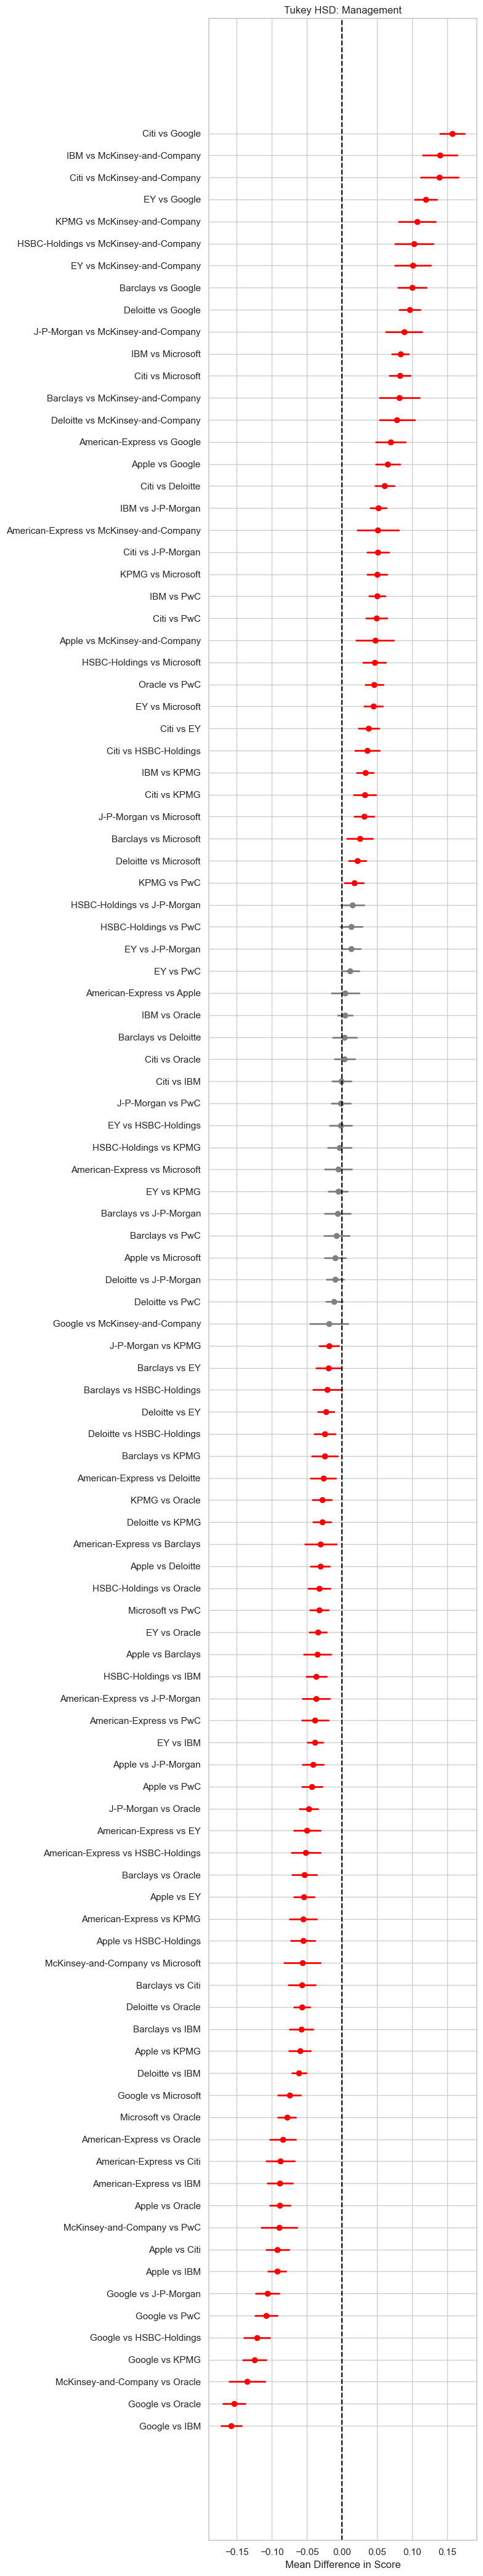


Tukey HSD for: Work-Life Balance
              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
       group1               group2        meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------
    American-Express                Apple  -0.0002    1.0 -0.0156  0.0153  False
    American-Express             Barclays  -0.0347    0.0 -0.0527 -0.0166   True
    American-Express                 Citi  -0.0805    0.0 -0.0963 -0.0648   True
    American-Express             Deloitte   -0.056    0.0   -0.07 -0.0419   True
    American-Express                   EY   -0.079    0.0 -0.0935 -0.0645   True
    American-Express               Google   0.0448    0.0  0.0286   0.061   True
    American-Express        HSBC-Holdings  -0.0618    0.0 -0.0784 -0.0451   True
    American-Express                  IBM  -0.0929    0.0 -0.1068 -0.0791   True
    American-Express           J-P-Morgan  -0.0335    0.0 -0.0486 -0.0185  

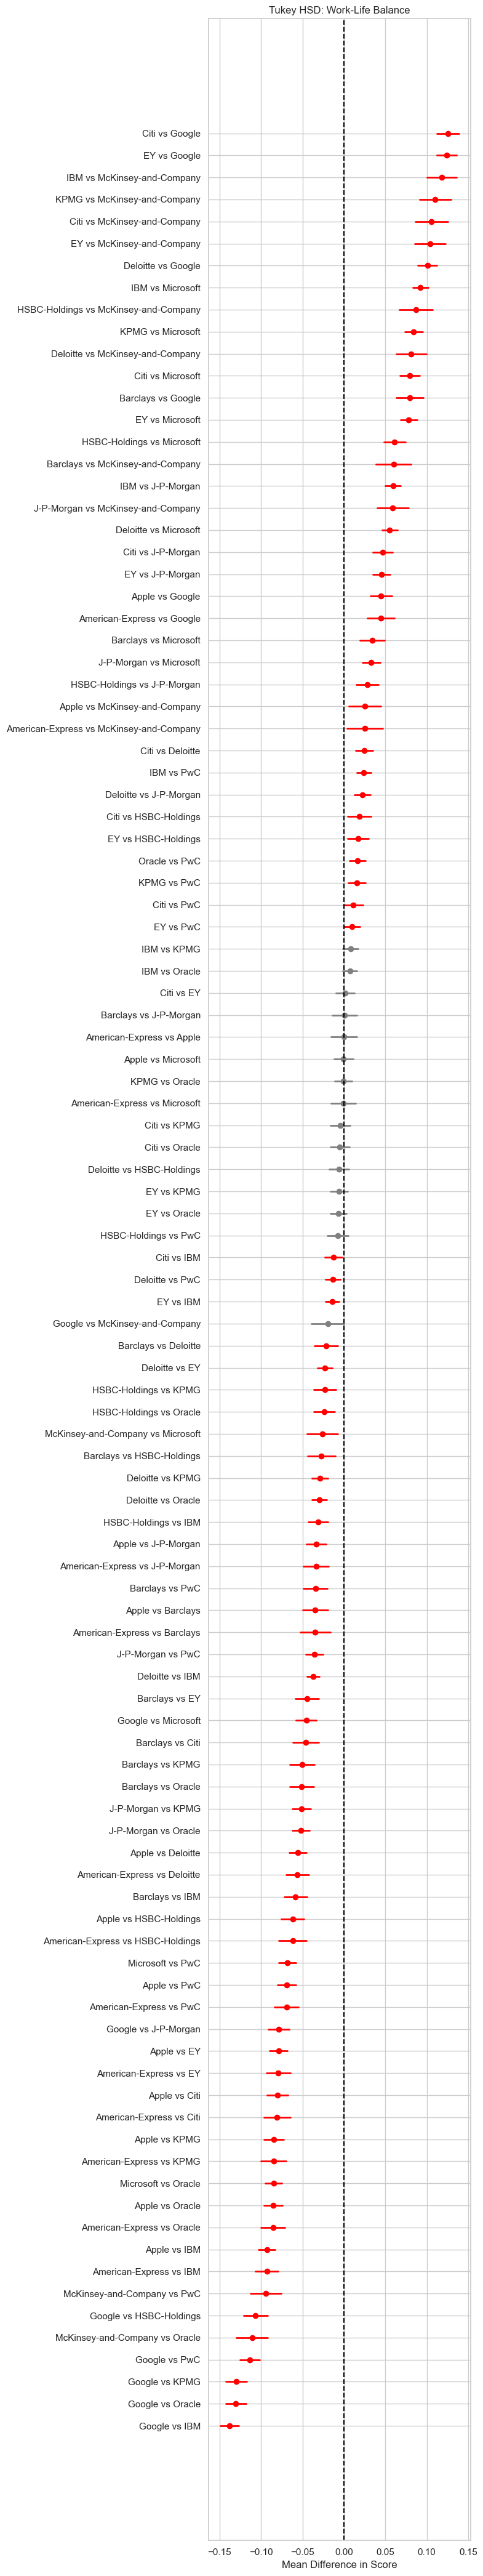


Tukey HSD for: Career Opportunities
              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
       group1               group2        meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------
    American-Express                Apple   0.0209 0.0009  0.0049  0.0369   True
    American-Express             Barclays  -0.0424    0.0 -0.0609 -0.0239   True
    American-Express                 Citi  -0.0784    0.0 -0.0946 -0.0622   True
    American-Express             Deloitte   -0.043    0.0 -0.0574 -0.0285   True
    American-Express                   EY   -0.067    0.0 -0.0819 -0.0521   True
    American-Express               Google   0.0537    0.0  0.0369  0.0706   True
    American-Express        HSBC-Holdings  -0.0687    0.0 -0.0858 -0.0516   True
    American-Express                  IBM  -0.0916    0.0 -0.1058 -0.0774   True
    American-Express           J-P-Morgan  -0.0261    0.0 -0.0415 -0.010

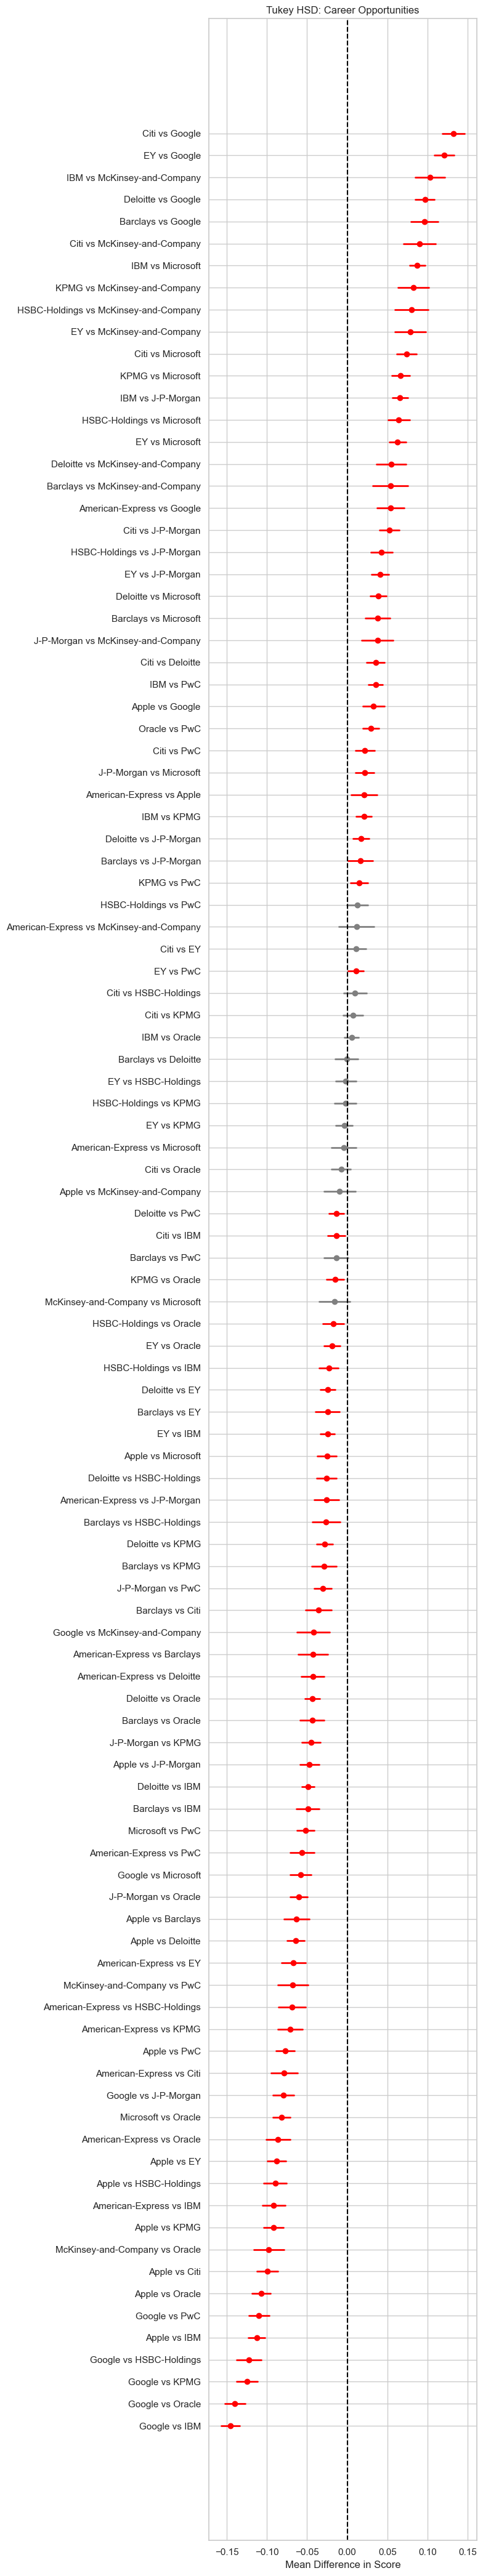


Tukey HSD for: Compensation & Benefits
              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
       group1               group2        meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------
    American-Express                Apple   0.0147 0.1152 -0.0013  0.0307  False
    American-Express             Barclays  -0.0333    0.0 -0.0521 -0.0144   True
    American-Express                 Citi  -0.0759    0.0 -0.0922 -0.0595   True
    American-Express             Deloitte  -0.0337    0.0 -0.0483  -0.019   True
    American-Express                   EY  -0.0567    0.0 -0.0718 -0.0416   True
    American-Express               Google   0.0596    0.0  0.0427  0.0765   True
    American-Express        HSBC-Holdings  -0.0642    0.0 -0.0816 -0.0469   True
    American-Express                  IBM  -0.1105    0.0 -0.1248 -0.0962   True
    American-Express           J-P-Morgan  -0.0323    0.0 -0.0479 -0.

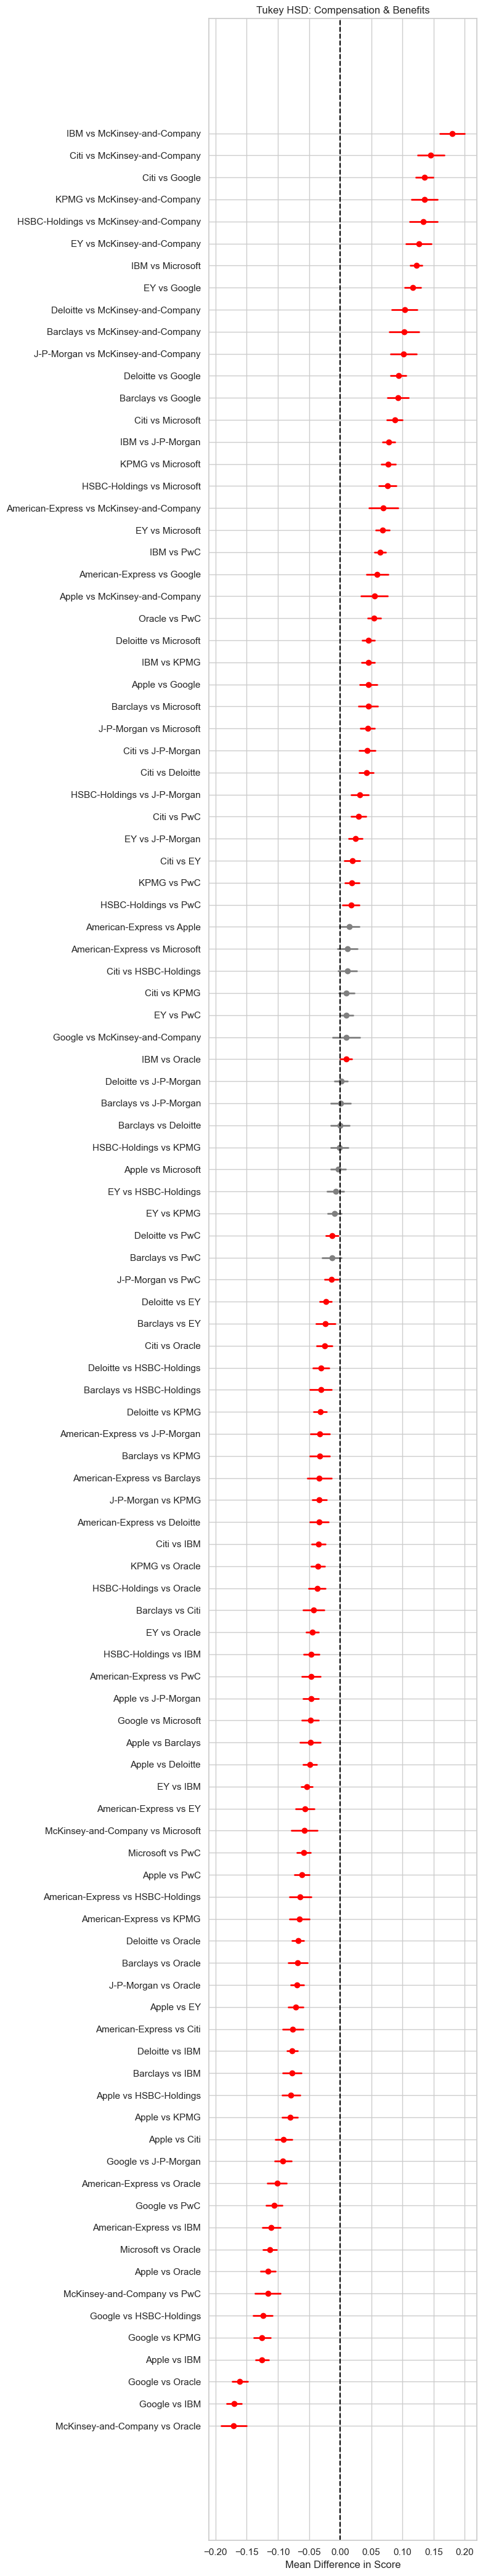


Tukey HSD for: Company Culture
              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
       group1               group2        meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------
    American-Express                Apple   0.0088 0.8505 -0.0069  0.0245  False
    American-Express             Barclays  -0.0361    0.0 -0.0544 -0.0178   True
    American-Express                 Citi  -0.0745    0.0 -0.0905 -0.0585   True
    American-Express             Deloitte  -0.0608    0.0 -0.0751 -0.0466   True
    American-Express                   EY  -0.0808    0.0 -0.0954 -0.0661   True
    American-Express               Google   0.0331    0.0  0.0167  0.0495   True
    American-Express        HSBC-Holdings  -0.0602    0.0 -0.0771 -0.0433   True
    American-Express                  IBM  -0.0997    0.0 -0.1136 -0.0857   True
    American-Express           J-P-Morgan  -0.0322    0.0 -0.0474  -0.017   T

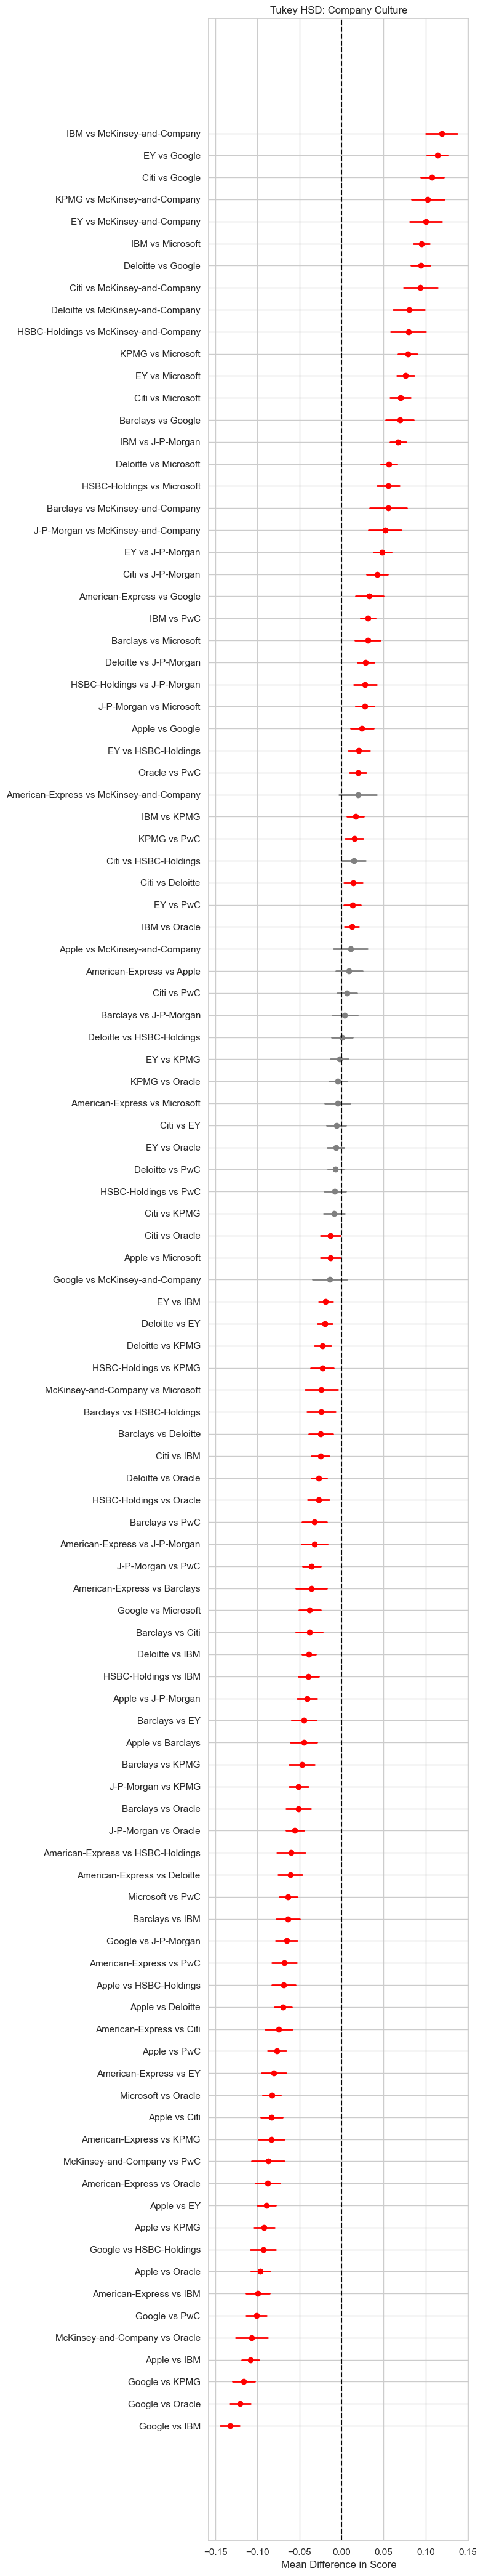

In [511]:
# Perform Tukey HSD to Compare Firms per Aspect
rating_cols = [
    "Management",
    "Work-Life Balance",
    "Career Opportunities",
    "Compensation & Benefits",
    "Company Culture"
]


# Melt to long format
long_df = final_df[["firm"] + rating_cols].melt(
    id_vars="firm", 
    var_name="aspect", 
    value_name="score"
).dropna()  # Drop missing scores

# Tukey HSD per aspect
for aspect in long_df["aspect"].unique():
    print(f"\nTukey HSD for: {aspect}")
    subset = long_df[long_df["aspect"] == aspect]

    if subset["firm"].nunique() < 2 or subset["score"].nunique() <= 1:
        print("Not enough variation for Tukey HSD.")
        continue

    tukey = pairwise_tukeyhsd(endog=subset["score"],
                              groups=subset["firm"],
                              alpha=0.05)

    # Summary
    print(tukey.summary())

    # Plot
    tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
    tukey_df["meandiff"] = tukey_df["meandiff"].astype(float)
    tukey_df["lower"] = tukey_df["lower"].astype(float)
    tukey_df["upper"] = tukey_df["upper"].astype(float)
    tukey_df["reject"] = tukey_df["reject"].astype(bool)
    
    # Sort by mean difference for clean plot
    tukey_df_sorted = tukey_df.sort_values(by="meandiff")
    
    plt.figure(figsize=(8, 0.4 * len(tukey_df_sorted)))
    for i, row in enumerate(tukey_df_sorted.itertuples()):
        color = "red" if row.reject else "gray"
        plt.plot([row.lower, row.upper], [i, i], color=color, lw=2)
        plt.plot(row.meandiff, i, 'o', color=color)
    
    # Y-ticks with group comparisons
    plt.yticks(range(len(tukey_df_sorted)), tukey_df_sorted["group1"] + " vs " + tukey_df_sorted["group2"])
    plt.axvline(x=0, color='black', linestyle='--')
    plt.title(f"Tukey HSD: {aspect}")
    plt.xlabel("Mean Difference in Score")
    plt.tight_layout()
    plt.show()

In [512]:
# Performance Evaluation Against Ground Truth Labels
# Load ground truth
ground_truth = pd.read_csv("filtered_reviews_with_industry.csv")

In [515]:
# Combine pros and cons to match review_text
ground_truth["review_text"] = (ground_truth["pros"].fillna("") + " " + ground_truth["cons"].fillna("")).str.strip()

In [517]:
ground_truth

,firm,job_title,date_review,overall_rating,work_life_balance,Company Culture,career_opp,comp_benefits,Management,pros,cons,industry,work_life_balance.1,Company Culture.1,career_opp.1,comp_benefits.1,Management.1,review_text
0,American-Express,Team Leader,14/05/2008,5,5,NaN,5,5,5,American Express is one of the most admired co...,"In my time at American Express, I have found t...",Finance,Neutral,Neutral,Positive,Positive,Negative,American Express is one of the most admired co...
1,American-Express,Travel Coordinator,17/05/2008,5,5,NaN,4,5,5,"The benefits, flexible work hours, room for gr...",can't think of any. I would say.. I would like...,Finance,Positive,Neutral,Positive,Positive,Neutral,"The benefits, flexible work hours, room for gr..."
2,American-Express,Team Leader,23/05/2008,5,5,NaN,5,5,5,Stable company on Dow Jones and more than 150 ...,"It's corporate America, as with any large comp...",Finance,Positive,Neutral,Positive,Neutral,Positive,Stable company on Dow Jones and more than 150 ...
3,American-Express,Senior Manager,26/05/2008,4,5,NaN,3,2,4,American Express has great people who are smar...,"Unfortunately, Amex does offer lower compensat...",Finance,Neutral,Positive,Neutral,Negative,Positive,American Express has great people who are smar...
4,American-Express,Director,39513,5,4,NaN,5,4,4,"Working with smart, mainly dedicated individua...",Compensation is not as good as with competitor...,Finance,Positive,Neutral,Positive,Negative,Neutral,"Working with smart, mainly dedicated individua..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,Barclays,,40094,5,3,NaN,4,3,3,growing firm - targeting top tier position - w...,brand - lack of culture - no eq biz - oldish p...,Finance,Neutral,Neutral,Neutral,Negative,Neutral,growing firm - targeting top tier position - w...
194,Barclays,Sales Assistant,17/08/2009,3,3,NaN,5,5,2,Benefits were probably the best part about wor...,Poor communication between Performance manager...,Finance,Neutral,Negative,Neutral,Positive,Negative,Benefits were probably the best part about wor...
195,Barclays,,22/08/2009,3,2,NaN,2,2,3,"Amount of responsibility given is quite good, ...",Lack of respect by senior employees to junior ...,Finance,Neutral,Negative,Neutral,Neutral,Neutral,"Amount of responsibility given is quite good, ..."
196,Barclays,Investment Banking Analyst,39973,2,3,NaN,1,3,3,Hard working and good people. Occasionally fe...,"domination, and how are you supposed to advanc...",Finance,Neutral,Positive,Neutral,Neutral,Neutral,Hard working and good people. Occasionally fe...


In [519]:
# ID columns and annotation columns
id_cols = ["firm", "job_title", "review_text"]
annotation_map = {
    "Work-Life Balance": "work_life_balance.1",
    "Company Culture": "Company Culture.1",
    "Compensation & Benefits": "comp_benefits.1",
    "Career Opportunities": "career_opp.1",
    "Management": "Management.1"
}

# Subset and rename annotation columns
ground_truth = ground_truth[id_cols + list(annotation_map.values())]
ground_truth = ground_truth.rename(columns={v: k for k, v in annotation_map.items()})



In [521]:
ground_truth

,firm,job_title,review_text,Work-Life Balance,Company Culture,Compensation & Benefits,Career Opportunities,Management
0,American-Express,Team Leader,American Express is one of the most admired co...,Neutral,Neutral,Positive,Positive,Negative
1,American-Express,Travel Coordinator,"The benefits, flexible work hours, room for gr...",Positive,Neutral,Positive,Positive,Neutral
2,American-Express,Team Leader,Stable company on Dow Jones and more than 150 ...,Positive,Neutral,Neutral,Positive,Positive
3,American-Express,Senior Manager,American Express has great people who are smar...,Neutral,Positive,Negative,Neutral,Positive
4,American-Express,Director,"Working with smart, mainly dedicated individua...",Positive,Neutral,Negative,Positive,Neutral
...,...,...,...,...,...,...,...,...
193,Barclays,,growing firm - targeting top tier position - w...,Neutral,Neutral,Negative,Neutral,Neutral
194,Barclays,Sales Assistant,Benefits were probably the best part about wor...,Neutral,Negative,Positive,Neutral,Negative
195,Barclays,,"Amount of responsibility given is quite good, ...",Neutral,Negative,Neutral,Neutral,Neutral
196,Barclays,Investment Banking Analyst,Hard working and good people. Occasionally fe...,Neutral,Positive,Neutral,Neutral,Neutral


In [523]:
# Merge predicted and ground truth data
merged_df = pd.merge(final_df, ground_truth, on=id_cols, suffixes=("_pred", "_true"))

In [524]:
merged_df.head(10)

,firm,job_title,review_text,Work-Life Balance_pred,Company Culture_pred,Compensation & Benefits_pred,Career Opportunities_pred,Management_pred,Work-Life Balance_true,Company Culture_true,Compensation & Benefits_true,Career Opportunities_true,Management_true
0,American-Express,Team Leader,American Express is one of the most admired co...,0.399,0.164,0.402,0.315,0.451,Neutral,Neutral,Positive,Positive,Negative
1,American-Express,Travel Coordinator,"The benefits, flexible work hours, room for gr...",0.544,0.727,0.727,0.727,NaN,Positive,Neutral,Positive,Positive,Neutral
2,American-Express,Team Leader,Stable company on Dow Jones and more than 150 ...,0.664,0.617,0.830,0.830,0.806,Positive,Neutral,Neutral,Positive,Positive
3,American-Express,Senior Manager,American Express has great people who are smar...,0.400,0.427,0.413,0.502,0.605,Neutral,Positive,Negative,Neutral,Positive
4,American-Express,Director,"Working with smart, mainly dedicated individua...",0.289,0.423,0.423,0.289,0.423,Positive,Neutral,Negative,Positive,Neutral
5,American-Express,Executive Assistant,Anerican Express is a very diverse organizatio...,-0.077,NaN,NaN,NaN,NaN,Negative,Positive,Positive,Positive,Positive
6,American-Express,Customer Care Professional,"Excellent Pay, Excellent Benefits, Great Oppor...",0.590,0.654,0.724,0.708,0.000,Positive,Positive,Neutral,Neutral,Negative
7,American-Express,Senior Marketing Analyst,Wonderful company to work for! Amex cares abou...,0.541,0.511,0.659,0.436,0.691,Positive,Positive,Positive,Positive,Positive
8,American-Express,Director,Work life balance. Professional development. ...,0.376,0.322,0.564,0.279,0.214,Positive,Positive,Neutral,Positive,Neutral
9,American-Express,Director,"Easy Commute, Prestigious company, Fun day Pol...",NaN,0.784,0.000,NaN,NaN,Positive,Positive,Positive,Positive,Positive


In [941]:
# Convert sentiment scores (ground truth labels) to discrete labels
label_map = {"Positive": 1, "Negative": -1, "Neutral": 0}

# Score to label conversion
def score_to_label(score, pos_thresh=0.80, neg_thresh= -.48):
    if pd.isna(score):
        return 0
    if score > pos_thresh:
        return 1
    elif score < neg_thresh:
        return -1
    else:
        return 0

In [943]:
# Print classification report and accuracy for each aspect
for aspect in annotation_map.keys():
    y_true = merged_df[f"{aspect}_true"].map(label_map).fillna(0)
    y_pred = merged_df[f"{aspect}_pred"].apply(score_to_label)

    print(f"\nEvaluation for: {aspect}")
    print(classification_report(
        y_true, y_pred,
        target_names=["Negative", "Neutral", "Positive"],
        digits=3,
        zero_division=0
    ))


Evaluation for: Work-Life Balance
              precision    recall  f1-score   support

    Negative      0.000     0.000     0.000        17
     Neutral      0.545     0.936     0.689       109
    Positive      0.615     0.105     0.180        76

    accuracy                          0.545       202
   macro avg      0.387     0.347     0.290       202
weighted avg      0.526     0.545     0.440       202


Evaluation for: Company Culture
              precision    recall  f1-score   support

    Negative      1.000     0.043     0.083        23
     Neutral      0.408     0.915     0.564        82
    Positive      0.529     0.093     0.158        97

    accuracy                          0.421       202
   macro avg      0.646     0.350     0.268       202
weighted avg      0.534     0.421     0.314       202


Evaluation for: Compensation & Benefits
              precision    recall  f1-score   support

    Negative      0.000     0.000     0.000        46
     Neutral      0.

In [945]:
# Accuracy Score per Aspect
for aspect in annotation_map.keys():
    y_true = merged_df[f"{aspect}_true"].map(label_map).fillna(0)
    y_pred = merged_df[f"{aspect}_pred"].apply(score_to_label)

    acc = accuracy_score(y_true, y_pred)
    print(f"{aspect} accuracy: {acc:.3f}")

Work-Life Balance accuracy: 0.545
Company Culture accuracy: 0.421
Compensation & Benefits accuracy: 0.436
Career Opportunities accuracy: 0.564
Management accuracy: 0.609
